<a href="https://colab.research.google.com/github/cacaalqorina/Membuat_Model_ML_dengan_Data_Time_Series.ipynb/blob/main/Submission_Membuat_Model_ML_dengan_Data_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('netflix.csv', parse_dates=['Date'])
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2002-05-23,1.242857,1.145714,1.156429,1.196429,104790000.0,1.196429
1,2002-05-24,1.225000,1.197143,1.214286,1.210000,11104800.0,1.210000
2,2002-05-28,1.232143,1.157143,1.213571,1.157143,6609400.0,1.157143
3,2002-05-29,1.164286,1.085714,1.164286,1.103571,6757800.0,1.103571
4,2002-05-30,1.107857,1.071429,1.107857,1.071429,10154200.0,1.071429


In [ ]:
df.isnull().sum()

Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [ ]:
df.shape

(4881, 7)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4881 entries, 0 to 4880
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       4881 non-null   datetime64[ns]
 1   High       4881 non-null   float64       
 2   Low        4881 non-null   float64       
 3   Open       4881 non-null   float64       
 4   Close      4881 non-null   float64       
 5   Volume     4881 non-null   float64       
 6   Adj Close  4881 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 267.1 KB


Text(0.5, 1.0, 'Unit yang terjual')

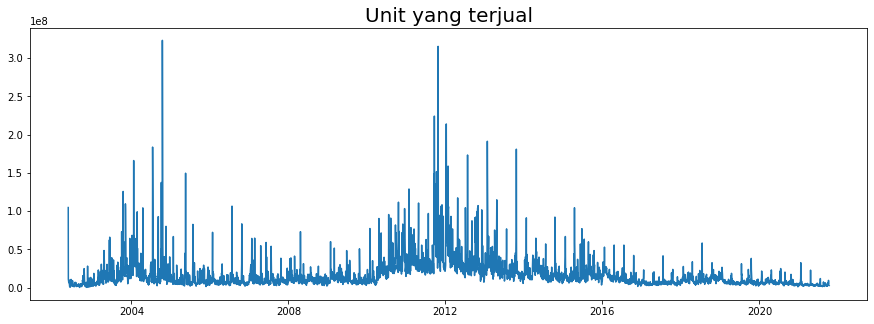

In [ ]:
dates = df['Date'].values
volume = df['Volume'].values

plt.figure(figsize=(15,5))
plt.plot(dates, volume)
plt.title('Unit yang terjual',
          fontsize=20)

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [ ]:
volume = volume.reshape(-1,1)
volume

array([[1.04790e+08],
       [1.11048e+07],
       [6.60940e+06],
       ...,
       [3.55690e+06],
       [3.27110e+06],
       [2.86120e+06]])

In [ ]:
scaler = MinMaxScaler()
volume = scaler.fit_transform(volume)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(volume, dates,
                                                    test_size=0.2,
                                                    shuffle=False)

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(X_test, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set  = windowed_dataset(X_train, window_size=60, batch_size=32, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True, input_shape = [None, 1]),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
threshold_mae = (volume.max() - volume.min()) * 10/100
print("Batas maksimal nilai mae (10%) dari data adalah sebesar", threshold_mae)

Batas maksimal nilai mae (10%) dari data adalah sebesar 0.1


In [ ]:
class myCallback(tf.keras.callbacks.Callback): 
  def on_epoch_end(self, epoch, logs={}): 
    if(logs.get('mae') < threshold_mae): 
      print("MAE < 10%") 
      self.model.stop_training = True 
callbacks = myCallback()

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,
                    epochs=100,
                    validation_data=test_set,
                    verbose=2,
                    callbacks=[callbacks])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


MAE < 10%
10/10 - 13s - loss: 3.9940e-04 - mae: 0.0232 - val_loss: 0.0039 - val_mae: 0.0598 - 13s/epoch - 1s/step
